In [4]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
import tensorflow_text
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

2023-03-26 19:03:22.810904: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 19:03:23.308668: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 19:03:23.310238: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 19:03:25.437796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


module https://tfhub.dev/google/universal-sentence-encoder-multilingual/3 loaded


In [3]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import numpy as np

#load pandas dataframe (rimuovo le righe vuote che putroppo sono presenti)
vax_series = pd.read_csv('data/posts_ULTRAcleaned_it_only_spacy.csv')
vax_series.dropna(inplace=True)

#salviamo una lista di lista con le parole tokenizzate
vax_text = vax_series['clean_text'].tolist()



In [7]:
import spacy
import pandas as pd
import regex as re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
it_stopwords = stopwords.words('italian')

#the stemmer requires a language parameter
snow_stemmer = SnowballStemmer(language='italian')

def cleaner(s):
    #removing numbers and special caracters
    s = re.sub(r'[^a-z\s]', '', s).strip()
    #remving multiple spaces
    s = " ".join(s.split()).strip()
    #some manual corrections
    #s = s.replace(' accino', ' vaccino')
    #removing stopwords with nltk
    s = stop_word_remover(s)
    #stemming with nltk
    s = stemmer(s)

    return s


def stop_word_remover(text):
    word_tokens = word_tokenize(text)
    word_list = [word for word in word_tokens if word.lower() not in it_stopwords]
    return " ".join(word_list)

def stemmer(text):
    words = word_tokenize(text)
    stem_words = [snow_stemmer.stem(word) for word in words]
    return " ".join(stem_words)

query = "Secondo tutte le leggi conosciute dell’aeronautica, non c’è modo che un ape sia in grado di volare. Le sue ali sono troppo piccole per sollevare il suo corpicino grassoccio da terra. L’ape, si sa, vola lo stesso. Perché alle api non interessa quello che gli uomini ritengono impossibile"
#query = "vaccino pfizer lanciato sul mercato: 1 morto e 3 feriti"
#query=cleaner(query)

print(query)


Secondo tutte le leggi conosciute dell’aeronautica, non c’è modo che un ape sia in grado di volare. Le sue ali sono troppo piccole per sollevare il suo corpicino grassoccio da terra. L’ape, si sa, vola lo stesso. Perché alle api non interessa quello che gli uomini ritengono impossibile


## Embedding

Vettorizziamo tutto il dataset di partenza. Per ogni frase viene prodotto un vettore a 512 dimensioni. A causa di un crash dovuto alla memoria non si può elaborare tutto il dataset ma solamente batch di 1000 frasi alla volta.

In [5]:
#Vettorizza a 512 dimensioni ogni frase
sentences_number = len(vax_text)
BATCH_SIZE = 1000

start = 0
stop = BATCH_SIZE
sentence_vector: np.ndarray = np.zeros((sentences_number, 512))
while sentences_number > 0:
    sentence_embeddings = model(vax_text[start:stop])
    sentence_vector[start:stop] = sentence_embeddings

    processed = stop - start
    sentences_number -= processed

    start = stop

    if sentences_number < BATCH_SIZE:
        stop += sentences_number
    else:
        stop += BATCH_SIZE

print("Shape of sentence vector: ", sentence_vector.shape)

In [ ]:
from scipy.spatial.distance import cosine, euclidean

for sent in vax_text[:10]:
  sim = 1 - cosine(query_vec, model([sent])[0])
  #sim = cosine(query_vec, sent)
  print("Sentence = ", sent, "; similarity = ", sim)

Sentence =  pronto affrontare settimana quirinale booster ; similarity =  0.19908323884010315
Sentence =  pass sanitaire guarigione booster pezzo dose migliore dellimmunite covid volere togliere scadenza spg tridosato autorizzare infettare natural arrestatele ; similarity =  0.3462800681591034
Sentence =  vaccinare bambino ricevere almeno dose Italia booster over piano notizia vaccare ; similarity =  0.30346691608428955
Sentence =  sereno sbrocchiamo periodo perch certezza curare grare riconoscente vaccinare booster fatelo vaccino obbligatorio ; similarity =  0.41252434253692627
Sentence =  vaccinare tredoso intero famiglia positivo covid influencer giornalista politico virologo commento proposito Greenpass booster tampono sivax novax emergenza ; similarity =  0.5320942997932434
Sentence =  giovane dovere dose booster unico scudo omicron ; similarity =  0.3732379376888275
Sentence =  booster ; similarity =  0.16326378285884857
Sentence =  continuare ce fregare draghi Milan Juventus int

In [ ]:
#vax_text

In [ ]:
import numpy as np
# k-means - Inertia as the number of clusters varies
from sklearn.cluster import KMeans
from sklearn import preprocessing  # to normalise existing X

#create a numpy array with all the vectors
vectors = np.zeros((len(sentence_embeddings), 512))
for i in range(len(sentence_embeddings)):
    vectors[i] = sentence_embeddings[i]

#normalize
vectors = preprocessing.normalize(vectors)

X_train_PCA = pd.DataFrame(vectors)

n_clusters = 2
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
# n_jobs = 2
kMeans_inertia = pd.DataFrame(data=[],index=range(2), \
columns=['inertia'])

kmeansfirst = KMeans(n_clusters=n_clusters, n_init=n_init, \
    max_iter=max_iter, tol=tol, random_state=random_state )
   
kmeansfirst.fit(X_train_PCA)

center = kmeansfirst.cluster_centers_
center.shape

(2, 512)

In [ ]:
kmeansfirst.score(X_train_PCA)

-11447.678045251776

In [ ]:
#calculating the distance from the 2 centers
from gensim import similarities
from scipy.spatial.distance import cosine, euclidean
import spacy
import pandas as pd
import regex as re
import numpy as np


#definiziamo una lista di frasi che dovrebbero essere classificate come anomalie
anomalies = ["il cane gioca a palla","ho dovuto ripristinare il PC per togliere tutti i suoi malware", "bella giornata oggi" ]
novax_sentences = ["i vaccini uccidono", "non mi voglio vaccinare", "no al booster", "dopo 4 dosi il sistema immunitario fritto", "i vaccini fanno morire le persone anche se ci dicono di no"]
#provo con un testo casuale
#testo = "i vaccini fanno morire le persone anche se ci dicono di no"
#test_vector = sbert_model.encode([anomalies])
#test_vector = model(testo)

cosine_distance = []
euclidean_distance = []
'''cosine_distance.append(  cosine(test_vector[0],center[0]) )
cosine_distance.append(  cosine(test_vector[0],center[1]) )
euclidean_distance.append (euclidean(test_vector[0],center[0]))
euclidean_distance.append(euclidean(test_vector[0],center[1]))

print("Distance score cosine 1 - 2:",cosine_distance[0],cosine_distance[1])
print("Distance score euclidean 1 - 2:",euclidean_distance[0],euclidean_distance[1])
print ("Euclidean distance sum:",sum(euclidean_distance))'''

print("Anomalies score:")
for i in anomalies:
   
    test_vector = model([i])

    cosine_distance = []
    euclidean_distance = []

    cosine_distance.append(  cosine(test_vector[0],center[0]) )
    cosine_distance.append(  cosine(test_vector[0],center[1]) )
    euclidean_distance.append (euclidean(test_vector[0],center[0]))
    euclidean_distance.append(euclidean(test_vector[0],center[1]))
   
    print ("Euclidean distance sum:",cosine_distance[0]+cosine_distance[1])

print("Novax score:")
for i in novax_sentences:
    test_vector = model([i])

    cosine_distance = []
    euclidean_distance = []

    cosine_distance.append(  cosine(test_vector[0],center[0]) )
    cosine_distance.append(  cosine(test_vector[0],center[1]) )
    euclidean_distance.append (euclidean(test_vector[0],center[0]))
    euclidean_distance.append(euclidean(test_vector[0],center[1]))
   
    print ("Euclidean distance sum:",cosine_distance[0]+cosine_distance[1])

Anomalies score:
Euclidean distance sum: 0.9886950861360096
Euclidean distance sum: 1.0876352980511506
Euclidean distance sum: 1.04280290646287
Novax score:
Euclidean distance sum: 1.7469873493631871
Euclidean distance sum: 0.9513516025978438
Euclidean distance sum: 1.3739042161596244
Euclidean distance sum: 0.9287548250062411
Euclidean distance sum: 1.0126217617669886


In [ ]:
[anomalies[1]]

['ho dovuto ripristinare il PC per togliere tutti i suoi malware']

In [ ]:
#Importing required modules
 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
 
#Load Data
data = sentence_embeddings
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(data)
 
df.shape



(19097, 2)

In [ ]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 1)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
print(label)


/home/apsev/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 0 ... 0 0 0]


In [ ]:
label.shape

for i in label:
    if i==1:
        print(i)

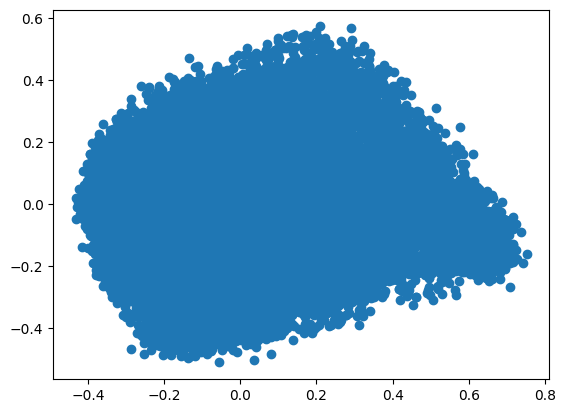

In [ ]:
import matplotlib.pyplot as plt
 
#filter rows of original data
filtered_label0 = df[label == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

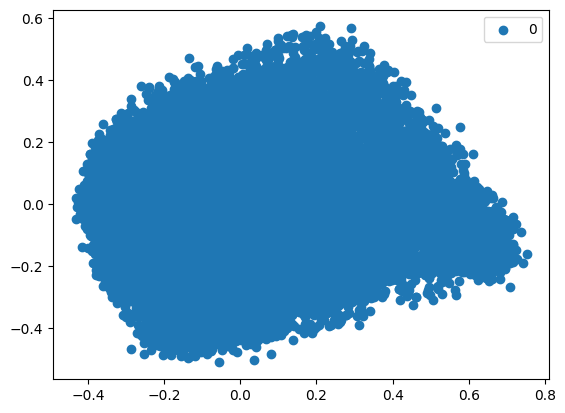

In [ ]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

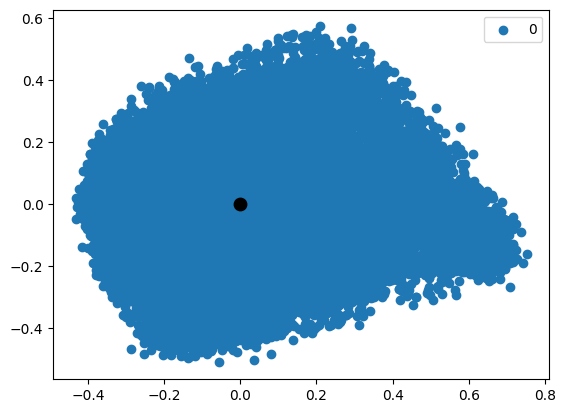

In [ ]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [ ]:
kmeans.silhouette_score(df)

AttributeError: 'KMeans' object has no attribute 'silhouette_score'

In [ ]:
#TODO: controllare lo score del cluster per vedere quanto è sparso 
# quante feature perdiamo utilizzando la PCA???? Rimane comunque significatvio???? 